In [1]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

from CIFAR10_helper import *
from model import *
from common import *

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
    except:
        pass

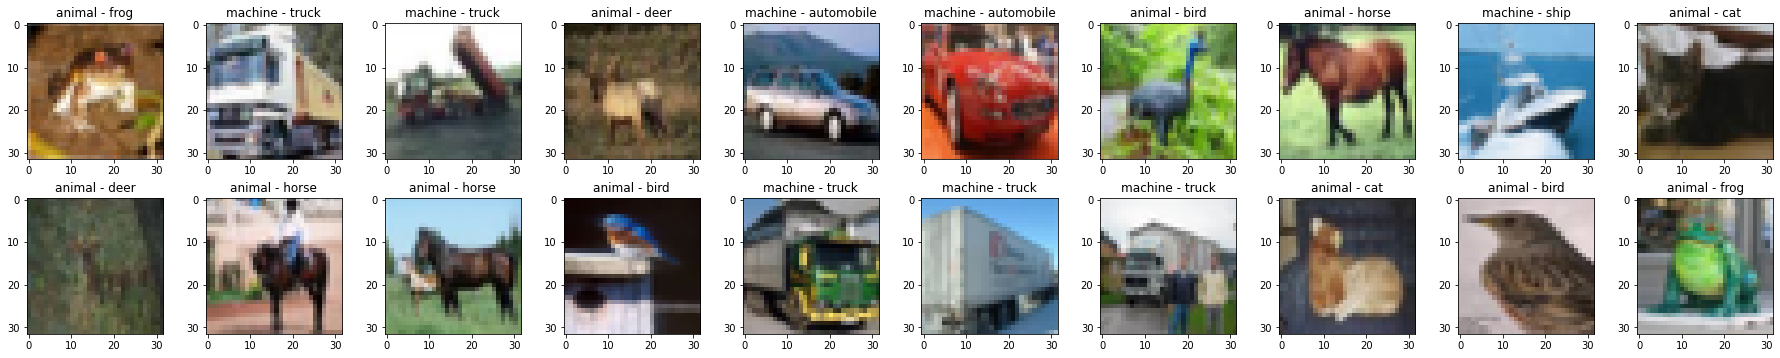

In [3]:
X, Y_super, Y_sub = get_cifar10()
plot_sample_images((X, Y_super, Y_sub), v_get_labels)

In [4]:
def create_classifier(img_input, n_classes,conv_dropout=0.2, fc_dropout=0.5, activation='relu', class_type = 'default', nodes = 64):
    x = vgg11(img_input,class_type=class_type)
    
    # FC Layers
    x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc1')(x)
    x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc2')(x)
    
    # Classification block    
    x = Dense(n_classes, activation='softmax', name=f'{class_type}_output')(x)
    
    return x

In [5]:
def create_model(plot=False):
    n_superclasses = 2
    n_subclasses = 10
    input_shape = x_train[0].shape

    img_input = Input(shape=input_shape, name='input')
    super_class_branch = create_classifier(img_input, 2 ,class_type = 'super')
    sub_class_branch = create_classifier(img_input, 10 ,class_type = 'sub')
    model = keras.Model(inputs=img_input,
                 outputs = [super_class_branch, sub_class_branch],
                 name="cifar10")
    
    if plot:
        fig = tf.keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=75)
        display(fig)
        
    init_lr = 1e-4
    lr_decay = 1e-6
    super_weight_ratio = 0.4

    opt = keras.optimizers.Adam(lr=init_lr, decay=lr_decay)

    model.compile(
        optimizer=opt,
        loss={
            'super_output':'categorical_crossentropy',
            'sub_output':'categorical_crossentropy'
        },
        metrics={
            'super_output':'accuracy',
            'sub_output':'accuracy'
        }, 
    )
    
    return model

Training on fold 1/5...


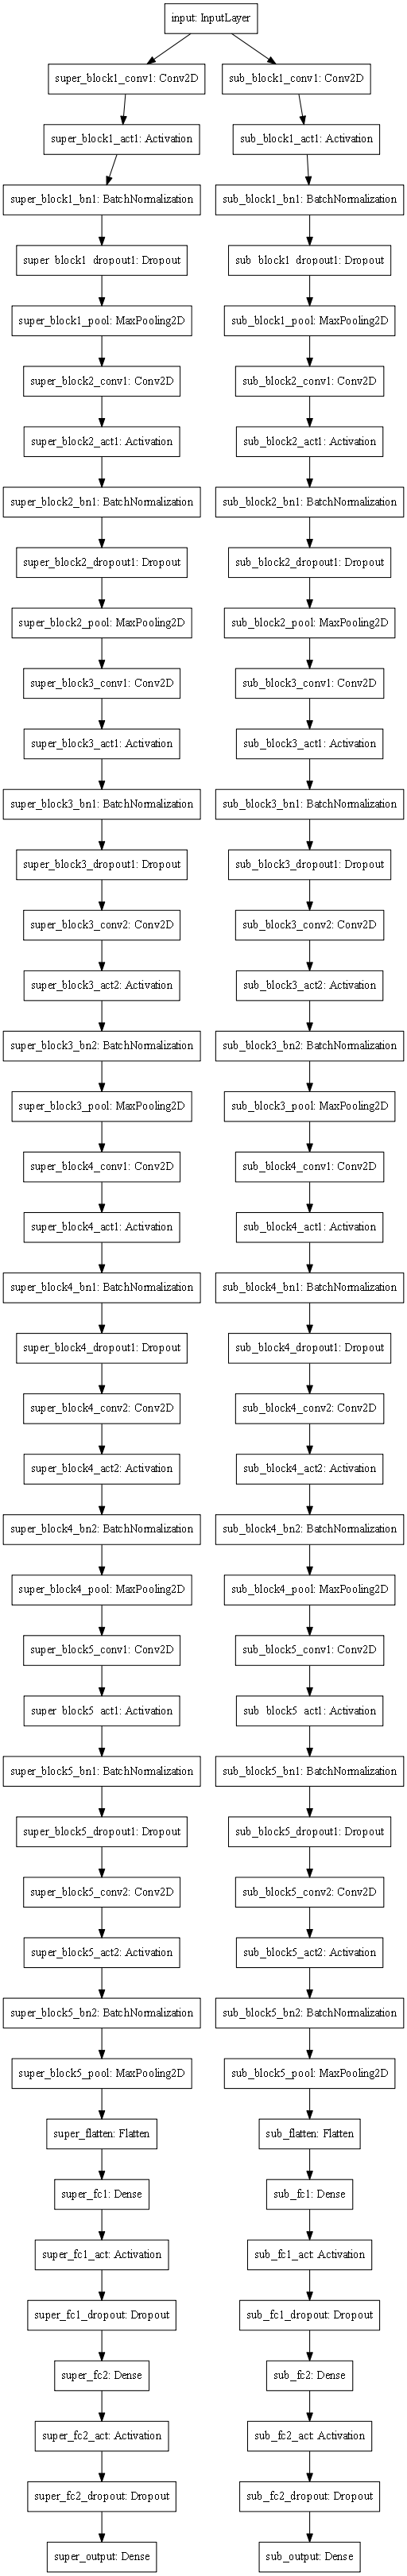

Epoch 1/80
75/75 [==============================] - 18s 175ms/step - loss: 3.5012 - super_output_loss: 0.7083 - sub_output_loss: 2.7929 - super_output_accuracy: 0.7412 - sub_output_accuracy: 0.1696 - val_loss: 3.0829 - val_super_output_loss: 0.7074 - val_sub_output_loss: 2.3756 - val_super_output_accuracy: 0.5980 - val_sub_output_accuracy: 0.0969
Epoch 2/80
75/75 [==============================] - 11s 148ms/step - loss: 2.2020 - super_output_loss: 0.3103 - sub_output_loss: 1.8917 - super_output_accuracy: 0.8739 - sub_output_accuracy: 0.3021 - val_loss: 3.5138 - val_super_output_loss: 0.8420 - val_sub_output_loss: 2.6718 - val_super_output_accuracy: 0.5980 - val_sub_output_accuracy: 0.0970
Epoch 3/80
75/75 [==============================] - 11s 148ms/step - loss: 1.9408 - super_output_loss: 0.2608 - sub_output_loss: 1.6800 - super_output_accuracy: 0.8963 - sub_output_accuracy: 0.3807 - val_loss: 4.1779 - val_super_output_loss: 0.8485 - val_sub_output_loss: 3.3293 - val_super_output_accu

In [6]:
stats =[]
n_splits = 5
epochs = 80
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
for index, (train_indices, val_indices) in enumerate(skf.split(X, np.zeros(len(X)))):
    print (f"Training on fold {index + 1}/{n_splits}...")
    x_train, y_super_train, y_sub_train = X[train_indices], Y_super[train_indices], Y_sub[train_indices]
    x_test, y_super_test, y_sub_test = X[val_indices], Y_super[val_indices], Y_sub[val_indices]
    model = None
    model = create_model(True if index == 0 else False)
    stats.append(train_and_predict(model, epochs, (x_train, y_super_train, y_sub_train), (x_test, y_super_test, y_sub_test)))
    reset_keras(model)

In [7]:
for i, stat in enumerate(stats):
    print(f"Fold {i + 1}: {stat}")

print("\n\nAverage [Super Class Error Rate, Sub Class Error Rate, Mismatch Rate]:")
for i in range(len(stats[0])):
    print(sum([x[i] for x in stats]) / len(stats))

Fold 1: (0.06275, 0.22841666666666666, 0.058916666666666666)
Fold 2: (0.06466666666666666, 0.24625, 0.06175)
Fold 3: (0.05491666666666667, 0.23808333333333334, 0.05483333333333333)
Fold 4: (0.06725, 0.23425, 0.056)
Fold 5: (0.06133333333333333, 0.23825, 0.05458333333333333)


Average [Super Class Error Rate, Sub Class Error Rate, Mismatch Rate]:
0.062183333333333334
0.23705000000000004
0.05721666666666666
